In [1]:
using Pkg
for p in ["Knet", "Plots", "IterTools","PyCall"]
    if !haskey(Pkg.installed(),p)
        Pkg.add(p);
    end
end
using DelimitedFiles
using Knet: KnetArray, accuracy, progress, minibatch, cycle, adam, sgd
using Plots
using IterTools: ncycle, takenth, take
using Base.Iterators: flatten
using LinearAlgebra

include("utils.jl")
include("utils2.jl")
include("models.jl")

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


In [36]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("pubmed")

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.107821 0.0; 0.0 0.0 … 0.0 0.0265838; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Int32[0 1 0; 0 1 0; … ; 1 0 0; 0 0 1], 1:140, 200:499, [18747, 19392, 19181, 18843, 19221, 18962, 19560, 19097, 18966, 19014  …  19499, 19663, 19508, 18871, 19528, 19500, 19307, 19288, 19594, 19271])

In [37]:
# TODO: take user inputs
struct args
    epochs
    lr
    weight_decay
    hidden
    pdrop
end

arguments = args(200, 0.01, 5e-4, 16, 0.5)

# Model and optimizer
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
#(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train])

In [39]:
output = model(features)

3×19717 Array{Float32,2}:
  0.696799   0.393462   0.266159  …   0.0219787  -0.0767673  -0.0258653 
 -0.82364   -0.497868  -0.123808     -0.176659    0.03647    -0.0282532 
  0.151479   0.414972   0.385905      0.173452    0.021363   -0.00784393

In [40]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

19717-element Array{Int64,1}:
 2
 2
 1
 3
 2
 3
 3
 2
 3
 2
 3
 3
 3
 ⋮
 1
 1
 3
 3
 3
 3
 1
 3
 1
 3
 1
 3

In [41]:
nll(output[:,idx_train], labels_decoded[idx_train])

1.5831853f0

In [42]:
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.25

In [43]:
using AutoGrad
J = @diff model(features, labels_decoded)
grad(J, params(model)[1])

16×500 Array{Float64,2}:
  0.140221    -0.0135467    -0.0228872   …  -0.0317029    -0.0251727 
 -0.00316591   0.00747988    0.00622512      0.0202898    -0.00210645
 -0.0462982    0.0236906     0.0347113       0.072492      0.0100658 
  0.0478199    0.0579368     0.165471        0.141736      0.0133053 
 -0.00874621  -0.00444061   -0.00569567      0.0683901     0.00159688
  0.00992767   0.00755232    0.017383    …   0.00360176    0.0280653 
 -0.00477681   0.000847234   0.00459725      0.00337243    0.00856991
 -0.02713      0.00623865    0.00740818      0.098756      0.00298789
  0.115465     0.00702021    0.027325        0.0139686    -0.00398654
 -0.0728361   -0.000103498   0.00619945      0.000990965  -0.00155356
 -0.00210103   0.0455978     0.0626478   …   0.112864      0.0121526 
  0.0149675   -0.0193107    -0.016057       -0.0103239    -0.00885497
  0.0046441    0.0288867     0.0329328       0.0645743     0.0275963 
 -0.00722253   0.00878699    0.0197746       0.044355      0.0100

In [44]:
dtrn =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{Array{Float32,2},Array{Int64,1}}}(Float32[0.0 0.0 … 0.107821 0.0; 0.0 0.0 … 0.0 0.0265838; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [2 2 … 1 3], 19717, 19717, false, 1, 1:19717, false, (500, 19717), (19717,), Array{Float32,2}, Array{Int64,1})

In [45]:
function train_with_results(model, dtrn, epoch, lr)
    training = adam(model, ncycle(dtrn, epoch), lr=lr)
    snapshot() = model(dtrn)
    snapshots = (snapshot() for x in takenth(progress(training),length(dtrn)))
    res = collect(flatten(snapshots))
    return res
end

train_with_results (generic function with 1 method)

┣████████████████████┫ [100.00%, 200/200, 01:15:21/01:15:21, 22.60s/i]           ┫ [29.50%, 59/200, 25:03/01:24:54, 21.31s/i] ███████▋            ┫ [38.50%, 77/200, 30:55/01:20:18, 32.41s/i] ▎         ┫ [51.50%, 103/200, 39:56/01:17:32, 40.00s/i] █████████████████▉  ┫ [89.50%, 179/200, 01:06:51/01:14:42, 30.47s/i]  ┫ [90.00%, 180/200, 01:07:32/01:15:03, 40.88s/i] ▍ ┫ [92.00%, 184/200, 01:09:27/01:15:30, 35.83s/i] 


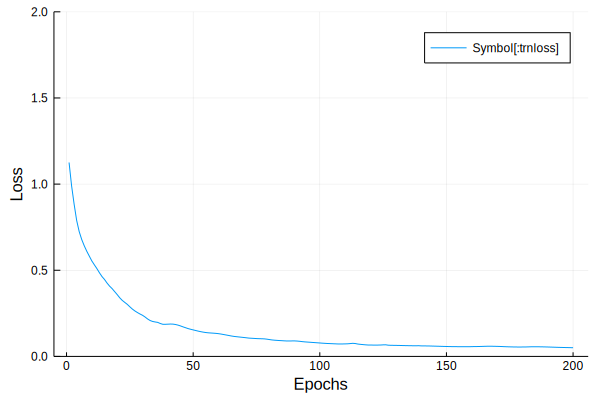

In [46]:
results = train_with_results(model, dtrn, arguments.epochs, arguments.lr)
trnloss = Array{Float32}(results)
plot(trnloss, ylim=(0.0,2.0),labels=[:trnloss],xlabel="Epochs",ylabel="Loss")

In [47]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

1.0

In [48]:
output = model(features)
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.755

In [49]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("citeseer")

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.0], 1:140, 200:499, [2488, 2644, 3261, 2804, 3176, 2432, 3310, 2410, 2812, 2520  …  2771, 2404, 2589, 3123, 3209, 2729, 3252, 2606, 2579, 2552])

In [50]:
# TODO: take user inputs
struct args
    epochs
    lr
    weight_decay
    hidden
    pdrop
end

arguments = args(200, 0.01, 5e-4, 16, 0.5)

# Model and optimizer
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
#(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train])

In [51]:
output = model(features)

6×3327 Array{Float32,2}:
 -0.0282952    -1.08009   -0.290713  …  -0.0266947  -0.0208543   -0.156791 
 -0.0279629    -2.10043   -0.101859     -0.31905     0.00352853  -0.402434 
 -0.106394     -4.27196   -0.278745     -0.511985   -0.346939    -0.687541 
 -0.102481     -5.72314   -0.230124     -0.917256   -0.18786     -0.415696 
 -0.0999042    -3.80381   -0.19789      -0.53368    -0.0862648   -0.608488 
 -0.000272881  -0.481439  -0.098823  …   0.0933717  -0.0388032   -0.0304674

In [52]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

3327-element Array{Int64,1}:
 4
 2
 6
 6
 4
 2
 4
 1
 4
 6
 3
 5
 3
 ⋮
 4
 3
 5
 5
 2
 2
 1
 4
 4
 4
 2
 6

In [53]:
nll(output[:,idx_train], labels_decoded[idx_train])

2.9856079f0

In [54]:
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.16428571428571428

In [55]:
using AutoGrad
J = @diff model(features, labels_decoded)
grad(J, params(model)[1])

16×3703 Array{Float64,2}:
 -0.0013665   -0.00601836   0.000101801  …   1.84405e-6  -1.26896e-5 
 -0.00204798  -0.0012766   -0.000231345      2.75141e-5   7.93611e-6 
  0.015739    -0.0138124   -0.00535814      -3.66764e-5  -1.55594e-5 
  0.0627877    0.0951389    0.000135445     -2.13147e-5   7.28156e-6 
  0.00363085  -9.83246e-5  -1.07472e-5       3.0072e-5   -1.80974e-5 
  0.0890455    0.116065     2.11779e-6   …  -2.81947e-5   2.57151e-5 
 -0.0404975   -0.0628019   -4.65378e-6      -3.40906e-5   1.58488e-5 
  0.0599957    0.327452    -3.28906e-5       2.062e-5     2.22754e-5 
  0.0308344    0.0625386   -0.0039568        3.32054e-5   0.000916004
  0.00443339   2.33465e-5   2.02562e-6      -3.54402e-5   1.63022e-5 
  0.0670998    0.167403    -3.67706e-6   …  -2.43489e-5   3.48657e-5 
  0.0195369    0.0281386    0.0073261        3.71505e-5  -1.59905e-5 
  0.0609409    0.0983985    0.00841948      -9.12112e-6   4.72243e-6 
  0.0291081    0.0657954   -0.00013277       3.80172e-5  -1.1789

In [56]:
dtrn =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{Array{Float32,2},Array{Int64,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [4 2 … 2 6], 3327, 3327, false, 1, 1:3327, false, (3703, 3327), (3327,), Array{Float32,2}, Array{Int64,1})

┣████████████████████┫ [100.00%, 200/200, 01:34/01:34, 2.13i/s] 


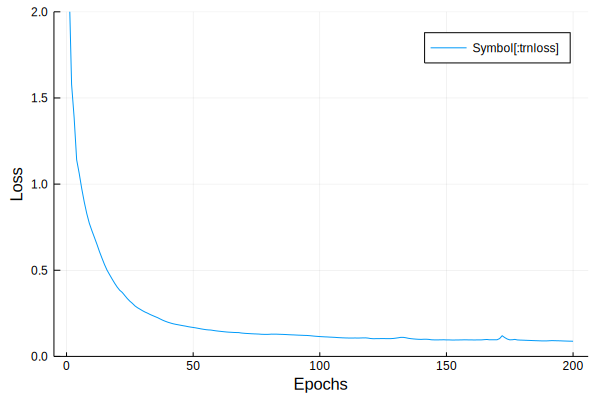

In [57]:
results = train_with_results(model, dtrn, arguments.epochs, arguments.lr)
trnloss = Array{Float32}(results)
plot(trnloss, ylim=(0.0,2.0),labels=[:trnloss],xlabel="Epochs",ylabel="Loss")

In [58]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.9928571428571429

In [59]:
output = model(features)
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.615

In [60]:
adj, features, labels, idx_train, idx_val, idx_test = load_dataset("cora")

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 1.0; 0.0 0.0 … 1.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Int32[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 0], 1:140, 200:499, [2692, 2532, 2050, 1715, 2362, 2609, 2622, 1975, 2081, 1767  …  1885, 2305, 2354, 2135, 2601, 1770, 1995, 2504, 1749, 2157])

In [61]:
# TODO: take user inputs
struct args
    epochs
    lr
    weight_decay
    hidden
    pdrop
end

arguments = args(200, 0.01, 5e-4, 16, 0.5)

# Model and optimizer
model = GCN(size(features,1),
            arguments.hidden,
            size(labels,2),
            adj,
            arguments.pdrop)

(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train]) + (arguments.weight_decay * sum(g.layer1.w .* g.layer1.w)) 
#(g::GCN)(x,y) = nll(g(x)[:, idx_train], y[idx_train])

In [62]:
output = model(features)

7×2708 Array{Float32,2}:
  0.432234    0.873347    5.71822   …   0.0585477    2.53292    4.06538 
  0.689667    0.200879    5.90231       0.00363735   0.205355   0.742619
  1.03491     0.819785   -0.436073      0.183907     1.40712    1.56423 
 -0.547828   -0.447869    0.316427     -0.1698      -1.36303   -1.60939 
 -0.0599395   0.0733874   2.15383      -0.0126753    0.640646   1.94103 
 -1.25647    -0.704935   -1.31062   …  -0.038438    -0.640925  -1.61464 
  0.0987769   0.11483     0.152831      0.0207511   -0.644775  -0.185346

In [63]:
labels_decoded = mapslices(argmax, labels ,dims=2)[:]

2708-element Array{Int64,1}:
 4
 5
 5
 1
 4
 3
 1
 4
 4
 3
 1
 1
 5
 ⋮
 4
 4
 4
 4
 4
 4
 1
 4
 4
 4
 4
 4

In [64]:
nll(output[:,idx_train], labels_decoded[idx_train])

3.8198195f0

In [65]:
accuracy(output[:,idx_train], labels_decoded[idx_train])

0.14285714285714285

In [66]:
using AutoGrad
J = @diff model(features, labels_decoded)
grad(J, params(model)[1])

16×1433 Array{Float64,2}:
  0.0128305   -0.321668    -0.106608    …   0.0843904   -0.0325401 
 -0.0142605   -0.0933405   -0.0432529       0.0073885    0.0327019 
 -0.0403899   -0.217125    -0.101366       -0.00388753  -0.0502696 
  0.0017137   -0.0520369   -0.0322658       0.0286356   -0.00952752
  0.035881     0.0804879    0.10566         0.0674038    0.0427712 
  0.00786779   0.00408645   0.00317382  …   0.028253     0.0130372 
 -0.0134141   -0.0424869   -0.0050832      -0.00443374  -0.029196  
  0.00335376  -0.0866217   -0.0540702       0.0119819   -0.0121484 
  0.0163136    0.123495     0.0503089       0.026611     0.0572487 
  0.0261336    0.0637742    0.0568259       0.0576763    0.0261168 
  0.003758     0.0433459    0.0705806   …   0.0285837    0.0476214 
  0.0948144    0.226794     0.318123        0.105274     0.0311318 
  0.0170185    0.0413308    0.0402443       0.0688385    0.0632295 
 -0.0129568   -0.00152533  -0.0216853      -0.0278178   -0.0160304 
  0.0564803    0.52806

In [67]:
dtrn =  minibatch(features, labels_decoded[:], length(labels_decoded))

Data{Tuple{Array{Float32,2},Array{Int64,1}}}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [4 5 … 4 4], 2708, 2708, false, 1, 1:2708, false, (1433, 2708), (2708,), Array{Float32,2}, Array{Int64,1})

┣████████████████████┫ [100.00%, 200/200, 00:34/00:34, 5.86i/s] 


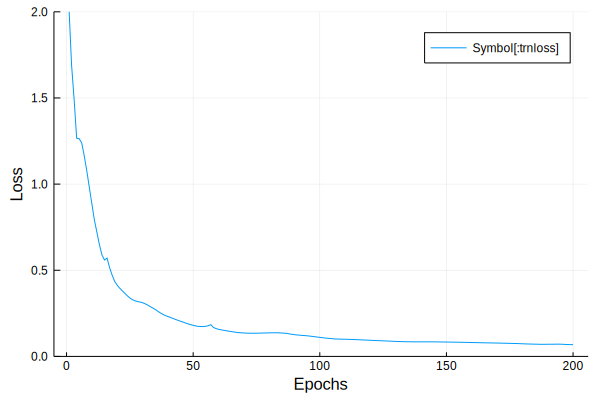

In [68]:
results = train_with_results(model, dtrn, arguments.epochs, arguments.lr)
trnloss = Array{Float32}(results)
plot(trnloss, ylim=(0.0,2.0),labels=[:trnloss],xlabel="Epochs",ylabel="Loss")

In [69]:
output = model(features)
accuracy(output[:,idx_train], labels_decoded[idx_train])

1.0

In [70]:
output = model(features)
accuracy(output[:,idx_test], labels_decoded[idx_test])

0.724